# Importing the Modules

The first 4 lines will make your code reproducible.

In [1]:
import numpy as np
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading Data

The "actual" file contains all 72 patients in the study and the labels.

In [2]:
actual_df = pd.read_csv('./DATA/kaggle_dataset/actual.csv')
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [3]:
actual_df['cancer'].value_counts()

cancer
ALL    47
AML    25
Name: count, dtype: int64

In [4]:
actual_df.shape

(72, 2)

Recode label to numeric.

In [5]:
y = actual_df.replace({'ALL':0, 'AML':1})
y = y.set_index('patient')
labels = ['ALL', 'AML']

C:\Users\lessickyeela\AppData\Local\Temp\ipykernel_32756\2421090632.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = actual_df.replace({'ALL':0, 'AML':1})


Loading training and testing datasets.

In [6]:
train_df = pd.read_csv('./DATA/kaggle_dataset/data_set_ALL_AML_train.csv')
test_df = pd.read_csv('./DATA/kaggle_dataset/data_set_ALL_AML_independent.csv')

In [7]:
print("Shape of Training Data: ", train_df.shape)
print("Shape of Testing Data: ", test_df.shape)

Shape of Training Data:  (7129, 78)
Shape of Testing Data:  (7129, 70)


In [8]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


The 7129 gene descriptions are provided as the rows and the values for each patient as the columns. This will clearly require some tidying up.

We can remove "call" columns from training and testing dataframes.

In [9]:
train_to_keep=[col for col in train_df.columns if "call" not in col]
test_to_keep=[col for col in test_df.columns if "call" not in col]

X_train = train_df[train_to_keep]
X_test = test_df[test_to_keep]

Now we can simply transpose both training and testing dataframes so that genes become columns(features) and patients become rows.

In [10]:
X_train = X_train.T
X_test = X_test.T

The first 2 rows are duplicated so we can remove 'Gene Description' and set 'Gene Accession Number' as the column headers.

In [11]:
X_train.columns = X_train.iloc[1]
X_test.columns = X_test.iloc[1]

X_train = X_train.drop(['Gene Description', 'Gene Accession Number'])
X_test = X_test.drop(['Gene Description', 'Gene Accession Number'])

Neither the training and testing row indexes are not in numeric order, so it's important that we reorder these, so that the labels will line up with the corresponding data.

In [12]:
X_train.index = X_train.index.astype(int)
X_train.sort_index(inplace=True)

X_test.index = X_test.index.astype(int)
X_test.sort_index(inplace=True)

In the end, our data looks like this:

In [13]:
print("Shape of Training data:\t", X_train.shape)
print("Shape of Testing Data:\t", X_test.shape)

Shape of Training data:	 (38, 7129)
Shape of Testing Data:	 (34, 7129)


In [14]:
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


Now let's split the target labels into training and testing targets.

In [15]:
y_train = y['cancer'][:38]
y_test = y['cancer'][38:]

## Standardizing Features

Note that the test set must use identical scaling to the training set.

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\lessickyeela\AppData\Local\Temp\ipykernel_32756\628790828.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(X_train.values), ax=ax[0]).set_title('Original Data')


C:\Users\lessickyeela\AppData\Local\Temp\ipykernel_32756\628790828.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(X_train_scaled), ax=ax[1]).set_title('Scaled Data')


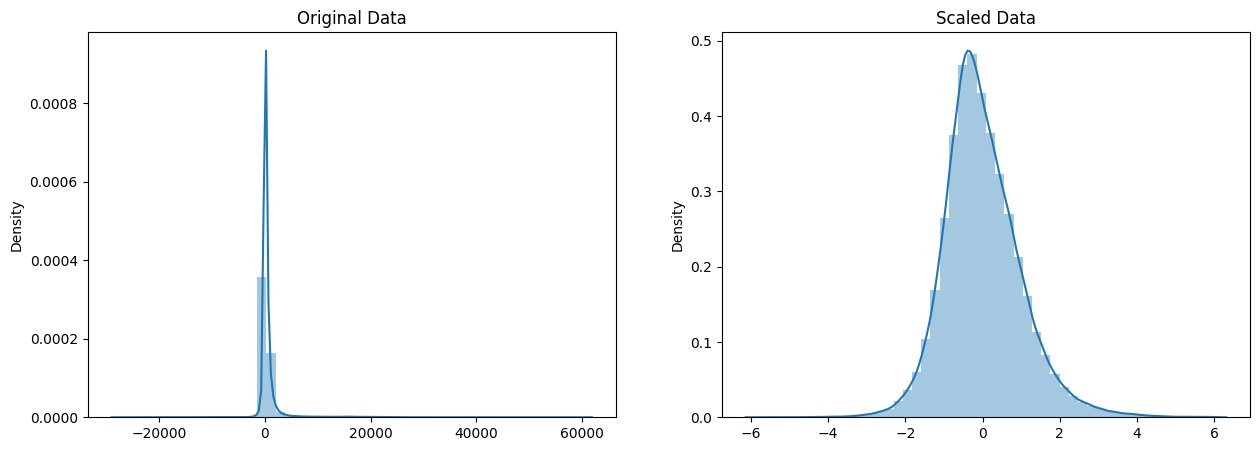

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.distplot(np.concatenate(X_train.values), ax=ax[0]).set_title('Original Data')
sns.distplot(np.concatenate(X_train_scaled), ax=ax[1]).set_title('Scaled Data')
plt.tight_layout
plt.show()

## Dimentionality reduction(PCA)

You need to apply the same PCA on training and testing sets.

In [18]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)

(38, 32)
(34, 32)


95% of variance is explained by 32 principal components. We can't plot something in 32 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments.

In [19]:
pca3 = PCA(n_components = 3).fit_transform(X_train_scaled)
colors = np.where(y_train==0, 'red', 'blue')
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors, cmap=plt.cm.Paired,linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.set_xticklabels([])
ax.set_ylabel("PC2")
ax.set_yticklabels([])
ax.set_zlabel("PC3")
ax.set_zticklabels([])
plt.show()

C:\Users\lessickyeela\AppData\Local\Temp\ipykernel_32756\3726565206.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors, cmap=plt.cm.Paired,linewidths=10)


<Figure size 640x480 with 0 Axes>

In [20]:
X_train_pca[1].shape

(32,)

# Neural Network

In [21]:
NN_model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=X_train_pca[1].shape),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

c:\Users\lessickyeela\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy']
)

NN_model.build()

In [23]:
# Check input and output specifications
print("Input shape:", NN_model.input_shape)
print("Output shape:", NN_model.output_shape)

Input shape: (None, 32)
Output shape: (None, 1)


In [24]:
import numpy as np
dummy_input = np.zeros((1, 32))  # Create a dummy input that matches the input shape
dummy_prediction = NN_model.predict(dummy_input)  # This will finalize the model's structure

print("Dummy Prediction:", dummy_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Dummy Prediction: [[0.]]


In [25]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

In [26]:
train_history = NN_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    batch_size = 8,
    epochs = 200,
    callbacks=[early_stopping]
)

Epoch 1/200


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - binary_accuracy: 0.3829 - loss: 8.9132 - val_binary_accuracy: 0.2941 - val_loss: 8.4065
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3529 - val_loss: 7.8520
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3529 - val_loss: 7.7707
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3824 - val_loss: 7.4070
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3529 - val_loss: 7.3730
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3824 - val_loss: 7.3581
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.4492 - loss: 8.8098 - val_binary_accuracy: 0.3824 - val_loss: 7.3500
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━

In [27]:
pred = (NN_model.predict(X_test_pca) > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [28]:
test_loss, test_mae = NN_model.evaluate(X_test_pca, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.3695 - loss: 6.1489 
Test Loss: 4.6566667556762695, Test MAE: 0.38235294818878174


In [29]:
import numpy as np

# Creating a dummy input array that matches the input shape
dummy_input = np.random.normal(size=(1, 32))

# Making a prediction to initialize everything
test_prediction = NN_model.predict(dummy_input)
print("Test prediction:", test_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Test prediction: [[-0.31747156]]


In [30]:
NN_model.save('NN_model.keras')
NN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,805 (18.77 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,204 (12.52 KB)

In [32]:
input_tensor = NN_model.layers[0].input
output_tensor = NN_model.layers[-1].output

print("Input Tensor: ", input_tensor)
print("Output Tensor: ", output_tensor)

Input Tensor:  <KerasTensor shape=(None, 32), dtype=float32, sparse=None, name=keras_tensor>
Output Tensor:  <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_3>


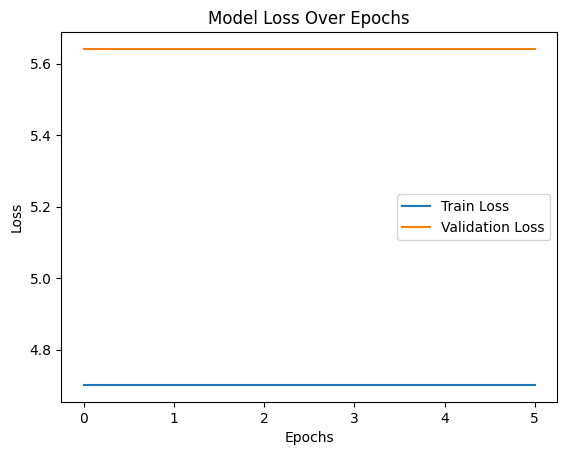

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['loss'], label='Train Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

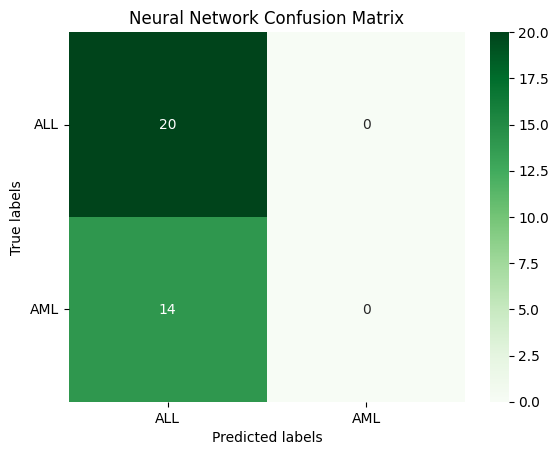

In [ ]:
cm_nn = confusion_matrix(y_test, pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);